In [1]:
%load_ext autoreload
%autoreload 2

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F

from htools import *
from incendio.layers import mish
from incendio.utils import get_einops_image, plot_img_batch

In [131]:
cd_root()

Current directory: /Users/hmamin/incendio


In [132]:
bs = 2
n_seq = 4
n_emb = 8

In [133]:
x = torch.randn(bs, n_seq, n_emb)
x.shape

torch.Size([2, 4, 8])

In [16]:
lin = nn.Linear(n_emb, n_emb*3)
qkv = lin(x)
qkv.shape

torch.Size([2, 4, 24])

In [17]:
q, k, v = qkv.chunk(3, dim=-1)

In [20]:
smap(q, k, v)

[torch.Size([2, 4, 8]), torch.Size([2, 4, 8]), torch.Size([2, 4, 8])]

In [21]:
qk = q @ k.transpose(-2, -1)
qk.shape

torch.Size([2, 4, 4])

In [22]:
w = F.softmax(qk/np.sqrt(k.shape[-1]), dim=-1)
w.shape

torch.Size([2, 4, 4])

In [23]:
w.shape, v.shape

(torch.Size([2, 4, 4]), torch.Size([2, 4, 8]))

In [24]:
w

tensor([[[0.3194, 0.2145, 0.2537, 0.2123],
         [0.1481, 0.3938, 0.1637, 0.2944],
         [0.3235, 0.2150, 0.2943, 0.1672],
         [0.2114, 0.3958, 0.1450, 0.2478]],

        [[0.1403, 0.1413, 0.4371, 0.2814],
         [0.1405, 0.1811, 0.4477, 0.2307],
         [0.2538, 0.2546, 0.2017, 0.2899],
         [0.1906, 0.2334, 0.2060, 0.3700]]], grad_fn=<SoftmaxBackward>)

In [25]:
w.sum(-1)

tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)

In [26]:
v

tensor([[[-0.9252, -0.7189,  0.5745, -0.0615, -0.8207, -0.2445,  0.1443,
           0.2584],
         [-0.1945,  0.0850,  0.6434,  0.5749,  0.2454, -0.1575, -0.2515,
           0.9941],
         [-0.3747, -0.3643,  0.0776,  0.1407, -0.7063, -0.2824,  0.0551,
           0.2374],
         [-0.4754,  0.6410,  0.0406, -0.0262,  0.4806, -1.2904, -0.1688,
           0.8364]],

        [[-0.8540,  0.4700,  0.0350,  0.1249,  0.2180, -0.8239,  0.5342,
           0.9115],
         [-0.6555, -0.1389,  0.0239, -0.5375, -0.3968, -1.3929, -0.4080,
           0.5622],
         [-0.0428, -0.5596,  0.8501,  0.3117, -0.2734,  0.3237,  0.3952,
           0.7681],
         [-0.4201,  0.8392,  0.4082,  0.9275,  0.6644,  0.3775,  0.9765,
           1.1330]]], grad_fn=<SplitBackward>)

In [27]:
res = w @ v
res.shape

torch.Size([2, 4, 8])

In [369]:
class Projector(nn.Module):
    """Project input into multiple spaces. Used in DotProductAttention to
    generate queries/keys/values.
    """
    
    def __init__(self, n_in, n_out_single=None, spaces=3):
        """
        Parameters
        ----------
        n_in: int
            Size of input feature dimension, where input is (bs, n_in) or
            (bs, seq_len, n_in). If the latter, this ONLY transforms the last 
            dimension. If you want to take multiple dimensions of information 
            into account simultaneously, you can flatten the input prior to 
            passing it in.
        n_out_single: int or None
            This determines the size of the feature dimension in each new 
            space. By default, this will be the same as n_in.
        spaces: int
            Number of spaces to project the input into. Default is 3 because
            we commonly use this to generate queries, keys, and values for
            attention computations.
        """
        super().__init__()
        self.spaces = spaces
        self.n_in = n_in
        self.n_out_single = n_out_single or n_in
        self.spaces = spaces
        self.n_out = self.n_out_single * self.spaces
        self.fc = nn.Linear(self.n_in, self.n_out)
        
    def forward(self, x):
        """
        Parameters
        ----------
        x: torch.Tensor
            Shape (bs, n_in) or (bs, seq_len, n_in).
            
        Returns
        -------
        tuple[torch.Tensor]: Tuple of `spaces` tensors where each tensor has
        shape (bs, n_out_single) or (bs, seq_len, n_out_single), depending on
        the input shape.
        """
        return self.fc(x).chunk(self.spaces, dim=-1)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Detour: testing fc projector vs conv projector

NOTE: nn.Linear only acts on last dimension so if we pass in input of shape (bs, seq_len, emb_dim), we're not really using the seq dimension here. Maybe refresh memory of 1d conv to see if that would take both into account in the way I want. Otherwise we could do some reshaping before feeding to linear layer.

UPDATE: Now that I think about this, maybe this behavior is desirable. At this stage we're not looking to take info from other time steps into account: we're just looking to get 3 different representations of EACH time step separately, and attention will be used to blend this information.

In [201]:
img = get_einops_image()
img_bw = get_einops_image(color=False)
img.shape, img_bw.shape

Object loaded from /Users/hmamin/.incendio/einops.zip.
Object loaded from /Users/hmamin/.incendio/einops.zip.


(torch.Size([6, 3, 96, 96]), torch.Size([6, 96, 96]))

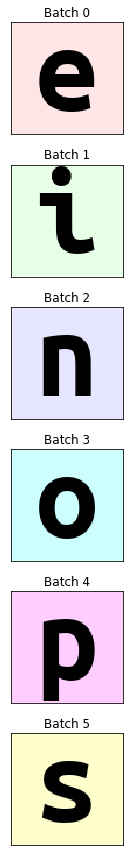

In [202]:
plot_img_batch(img)

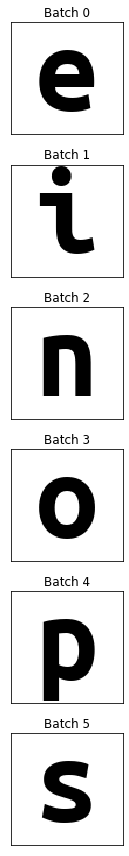

In [203]:
plot_img_batch(img_bw)

In [204]:
proj = Projector(*img_bw.shape[1:], 3)
with torch.no_grad():
    proj.fc.weight.data.fill_(2)
    
qkv = torch.cat(proj(img_bw), dim=0)
qkv.shape

torch.Size([18, 96, 96])

In [221]:
# Because we filled weights with constant, q/k/v are all equivalent for a 
# single sample. Precision is low for some reason (e.g. tolerance of 1e-3
# finds differences).
for i in range(6):
    print(i)
    assert torch.isclose(qkv[i], qkv[i+6], 1e-2, 1e-2).float().mean() == 1
    assert torch.isclose(qkv[i], qkv[i+12], 1e-2, 1e-2).float().mean() == 1

0
1
2
3
4
5


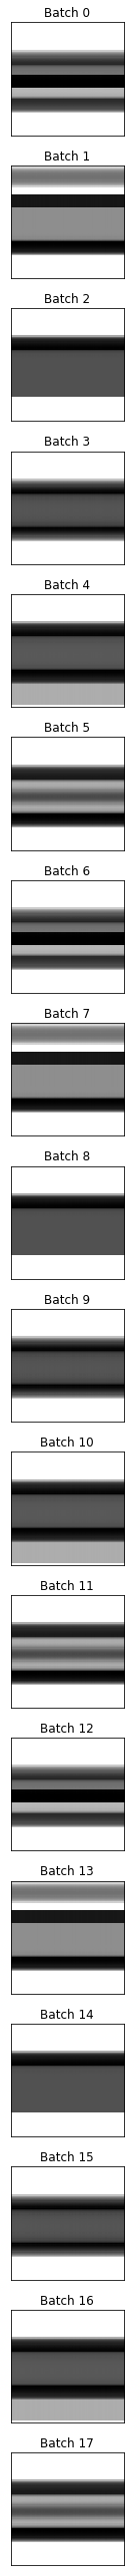

In [205]:
plot_img_batch(qkv)

In [195]:
conv = nn.Conv1d(img_bw.shape[-1], img_bw.shape[-1]*2, 
                 kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight.data.fill_(2)
# bw_out = conv(img_bw.permute(0, 2, 1))
bw_out = conv(img_bw)
bw_out.shape

torch.Size([6, 192, 96])

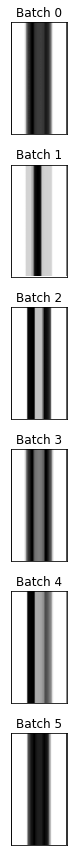

In [196]:
plot_img_batch(bw_out)

In [181]:
bw_out.shape[1]

4608

torch.Size([6, 2304])


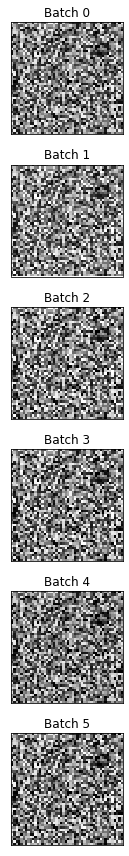

In [184]:
fc = nn.Linear(img_bw.shape[-1] * img_bw.shape[-2], 
               img_bw.shape[-1] * img_bw.shape[-2] // 4)
with torch.no_grad():
    fc.weight.data.fill_(2)
bw_out = fc(img_bw.view(img_bw.shape[0], -1))
plot_img_batch(
    bw_out.view(bw_out.shape[0], int(np.sqrt(bw_out.shape[1])), -1)
)

In [370]:
class DotProductAttention(nn.Module):
    """GPT2-style attention block. This was mostly an intuition-building
    exercise - in practice, Huggingface provides layers that should probably
    be used instead.
    """
    
    def __init__(self, n_in, n_out=None, nf=None, n_heads=12,
                 temperature='auto', p1=0.1, p2=0.1, return_attn=False):
        """
        Parameters
        ----------
        n_in: int
            Last dimension of input, usually embedding dimension.
        n_out: int or None
            Size of output vectors. By default, this will be the same as the 
            input.
        nf: int or None
            Size ("nf = number of features") of queries/keys/values. 
            By default, this will be the same as n_in. Must be divisible by
            n_heads.
        n_heads: int
            Number of attention heads to use. nf must be divisible
            by this as each projected vector will be divided evenly among
            each head.
        temperature: str or float
            If str, must be "auto", meaning softmax inputs will be scaled by
            sqrt(n_proj_single). You can also specify a float, where values
            <1 sharpen the distribution (usually not what we want here) and
            values greater than one soften it (allowing attention head to 
            route more information from multiple neurons rather than almost 
            all from one).
        p1: float
            Value in (0.0, 1.0) setting the dropout probability on the 
            attention weights.
        p2: float
            Value in (0.0, 1.0) setting dropout probability following the 
            output layer.
        return_attn: bool
            If True, the `forward` method will return a tuple of 
            (output, attention_weights) tensors. If False (the default), just
            return the output tensor.
        """
        super().__init__()
        nf = nf or n_in
        n_out = n_out or n_in
        assert nf % n_heads == 0, \
            'n_proj_single must be divisible by n_heads'
        
        self.proj_in = Projector(n_in, nf, spaces=3)
        # Reshape so hidden dimension is split equally between each head.
        self.head_splitter = Rearrange('bs seq (heads f) -> bs heads seq f', 
                                       heads=n_heads)
        self.soft = SmoothSoftmax(temperature)
        self.drop_attn = nn.Dropout(p1)
        # Concatenate output of each head.
        self.head_merger = Rearrange('bs heads seq f -> bs seq (heads f)')
        self.fc_out = nn.Linear(nf, n_out)
        self.drop_out = nn.Dropout(p2)
    
        # Non-layer attributes.
        self.n_heads = n_heads
        self.temperature = temperature
        self.p1 = p1
        self.p2 = p2
        self.return_attn = return_attn
        
    def forward(self, x):
        """
        Parameters
        ----------
        x: torch.Tensor
            Shape (bs, seq_len, n_in). n_in will usually be the sum of
            embedding dimensions (word and positional). For other problems
            (e.g. web browsing sequence classificaiton), this might include
            other features about the page at time step T.
        """
        q, k, v = map(self.head_splitter, self.proj_in(x))
        scores = q @ k.transpose(-2, -1)
        weights = self.drop_attn(self.soft(scores))
        x = weights @ v
        x = self.head_merger(x)
        x = self.drop_out(self.fc_out(x))
        return (x, weights) if self.return_attn else x

In [364]:
print(x.shape)
z = attn.head_splitter(x)
print(z.shape)
merger = Rearrange('bs heads seq f -> bs seq (heads f)')
merger(z).shape

torch.Size([2, 6, 768])
torch.Size([2, 12, 6, 64])


torch.Size([2, 6, 768])

In [365]:
bs = 2
seq_len = 6
n_emb = 768
n_heads = 12
x = torch.randn(bs, seq_len, n_emb)
print(x.shape)

attn = DotProductAttention(n_emb, n_heads=n_heads)
res = attn(x)
print(res.shape)

torch.Size([2, 6, 768])
torch.Size([2, 6, 768])


In [366]:
attn = DotProductAttention(n_emb, n_heads=3)
res = attn(x)
res.shape

torch.Size([2, 6, 768])

In [371]:
class FanForward(nn.Module):
    """Fan out to a larger dimension and back in to the original space.
    Not fully clear on why this is necessary or useful but we apparently need
    it for our GPT2-esque decoder.
    """
    
    def __init__(self, n_in, n_hid=None, scalar=4, p=0.1, act=mish):
        """
        Parameters
        ----------
        n_in: int
            Number of input features. x will typically have shape 
            (bs, seq_len, n_in).
        n_hid: int or None
            If int, this will be the size of the output of the first linear 
            layer. If None, hidden_scalar will be used to determine this.
        scalar: int
            In practice, we often want our hidden layer to produce outputs
            of n_in*n where n is some semi-arbitrary scalar. If n_hid is None,
            this scalar will be used to compute n_hid from n_in.
        p: float
            Dropout probability. Value in (0.0, 1.0). This is applied after 
            the output layer but not the input layer for some reason.
        act: nn.Module or function
            Callable activation function. This will be used after both the
            first and second linear layers.
        """
        super().__init__()
        n_hid = ifnone(n_hid, n_in * scalar)
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, n_in)
        self.act = act
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        """
        Parameters
        ----------
        x: torch.Tensor
            Shape (bs, n_in) or (bs, seq_len, n_in).
            
        Output
        ------
        torch.Tensor: Same shape as input tensor.
        """
        x = self.act(self.fc1(x))
        return self.drop(self.act(self.fc2(x)))

In [351]:
ff = FanForward(24, 2)
ff(res).shape

torch.Size([2, 4, 24])

In [373]:
class TransformerDecoder(nn.Module):
    """GPT2-esque decoder network. This was mostly an intuition-building
    exercise - in practice, it's probably best to just use something from 
    Huggingface.
    """
    
    def __init__(self, n_in=768, n_heads=12):
        super().__init__()
        self.attn = DotProductAttention(n_in, n_heads=n_heads)
        self.ff = FanForward(n_in)
        self.norm_1 = nn.LayerNorm(n_in)
        self.norm_2 = nn.LayerNorm(n_in)
        
    def forward(self, x):
        x += self.attn(self.norm_1(x))
        return x + self.ff(self.norm_2(x))

In [374]:
FanForward(5, 6)

FanForward(
  (fc1): Linear(in_features=5, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=5, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
)

In [375]:
ff = FanForward(n_emb, 4)
ff(x).shape

torch.Size([2, 6, 768])

In [376]:
decoder = TransformerDecoder()
decoder

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TransformerDecoder(
  (attn): DotProductAttention(
    (proj_in): Projector(
      (fc): Linear(in_features=768, out_features=2304, bias=True)
    )
    (head_splitter): Rearrange('bs seq (heads f) -> bs heads seq f', heads=12)
    (soft): SmoothSoftmax(
      (act): Softmax(dim=-1)
    )
    (drop_attn): Dropout(p=0.1, inplace=False)
    (head_merger): Rearrange('bs heads seq f -> bs seq (heads f)')
    (fc_out): Linear(in_features=768, out_features=768, bias=True)
    (drop_out): Dropout(p=0.1, inplace=False)
  )
  (ff): FanForward(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (norm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [379]:
x.shape

torch.Size([2, 6, 768])

In [378]:
decoder(x).shape

torch.Size([2, 6, 768])

In [156]:
from transformers.modeling_gpt2 import Attention

In [166]:
config = Args(n_head=1, attn_pdrop=.1, resid_pdrop=.1, n_ctx=n_emb*2, 
              n_layer=1, n_embd=n_emb, layer_norm_epsilon=1e-3,
              output_attentions=False)
attn_gpt = Attention(n_emb, n_emb*2, config)
res_gpt = attn_gpt(x)
len(res_gpt)

2

In [169]:
res_gpt[-2].shape

torch.Size([2, 4, 3])

In [171]:
attn_gpt.c_attn(x).shape

torch.Size([2, 4, 9])

In [61]:
# FROM BLOG POST
class Conv1D(nn.Module):
    def __init__(self, nx, nf):
        super().__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x
    
class FeedForward(nn.Module):
    def __init__(self, dropout, d_model=768, nx=768*4):
        super().__init__()
        self.c_fc    = Conv1D(d_model, nx)
        self.c_proj  = Conv1D(nx, d_model)
        self.act     = F.gelu
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.act(self.c_fc(x))
        print(x.shape)
        return self.dropout(self.c_proj(x))

In [62]:
FeedForward(0, n_emb, n_emb*4)(x).shape

torch.Size([2, 4, 12])


torch.Size([2, 4, 3])

In [54]:
w.shape, v.shape

(torch.Size([2, 4, 4]), torch.Size([2, 4, 3]))

In [27]:
z = torch.randn(bs, n_seq, n_emb, n_emb)
z.shape

torch.Size([2, 4, 3, 3])

In [30]:
lin2 = nn.Linear(3, 5)
lin2(z).shape

torch.Size([2, 4, 3, 5])

In [33]:
lin2.weight

Parameter containing:
tensor([[-0.5565, -0.2874, -0.5044],
        [ 0.3084,  0.2368, -0.2929],
        [-0.1206,  0.0814, -0.2280],
        [ 0.1191,  0.0834, -0.2181],
        [-0.0737,  0.3648,  0.3930]], requires_grad=True)

In [34]:
z.dim()

4